# Class

In [1]:
import sys
sys.path.append('/home/phzd/AI/bidd-molmap_v1_3')
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import roc_auc_score, precision_recall_curve
from sklearn.metrics import auc as calculate_auc
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from sklearn.utils import shuffle 
from joblib import load, dump
import numpy as np
import pandas as pd
import os,time,json
from molmap import feature,loadmap
from scipy.stats.stats import pearsonr
from argparse import ArgumentParser
import xgboost
import shap

In [2]:
def PRC_AUC(y_true, y_score):
	precision, recall, threshold  = precision_recall_curve(y_true, y_score) #PRC_AUC
	auc = calculate_auc(recall, precision)
	return auc

def ROC_AUC(y_true, y_score):
	auc = roc_auc_score(y_true, y_score)
	return auc

In [3]:
df=pd.read_csv('CB2_Chembl_C7758.csv')
Y0 = df['threshold4'].astype('int').values
len(Y0)

7758

In [4]:
def random_split(df, random_state, split_size = [0.8, 0.1, 0.1]):
	base_indices = np.arange(len(df)) 
	base_indices = shuffle(base_indices, random_state = random_state) 
	nb_test = int(len(base_indices) * split_size[2]) 
	nb_val = int(len(base_indices) * split_size[1]) 
	test_idx = base_indices[0:nb_test] 
	valid_idx = base_indices[(nb_test):(nb_test+nb_val)] 
	train_idx = base_indices[(nb_test+nb_val):len(base_indices)] 
	print(len(train_idx), len(valid_idx), len(test_idx)) 
	return train_idx, valid_idx, test_idx 

In [5]:
import json
with open('params_class','r') as f:
    best_param=json.load(f)

In [6]:
use_param=best_param['params']
for item in ['gpu_id','tree_method','missing']:
    use_param.pop(item)
use_param.update({'n_jobs': -1})

In [7]:
import time
clf=xgboost.XGBClassifier(**use_param)

In [8]:
X0=pd.read_csv('Mo_Pu_ma_c.csv')
len(X0)

7758

In [9]:
seed = 256
X0=X0.values
train_idx, valid_idx, test_idx = random_split(df,random_state=seed)
train_idx = [i for i in train_idx if i < len(df)]
valid_idx = [i for i in valid_idx if i < len(df)]	
test_idx = [i for i in test_idx if i < len(df)]	
print(len(train_idx), len(valid_idx), len(test_idx)) 
X = X0[train_idx]; y = Y0[train_idx]
X_valid = X0[valid_idx];y_valid = Y0[valid_idx]
X_test = X0[test_idx]; y_test = Y0[test_idx] 

6208 775 775
6208 775 775


In [14]:
import time
clf=xgboost.XGBClassifier(**use_param)
time1=time.time()
#model = xgboost.XGBRegressor(objective='reg:squarederror').fit(X, y)
model=clf.fit(X, y)
time2=time.time()
time_fit=time2-time1
print(f"fit time is: {time_fit}")

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[08:29:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
fit time is: 273.82618260383606


In [15]:
explainer = shap.Explainer(model)
shap_values = explainer(X)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


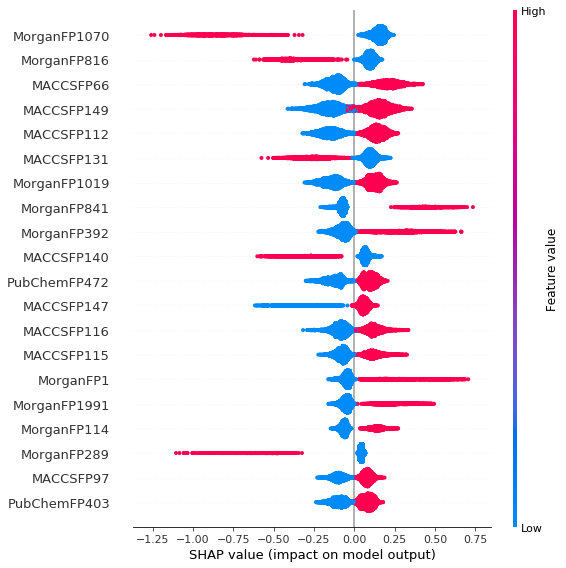

In [16]:
shap.summary_plot(shap_values, X)